Progress: 100%|█████████████████████████████████████████| Time: 0:00:01
Progress: 100%|█████████████████████████████████████████| Time: 0:06:02
Progress: 100%|█████████████████████████████████████████| Time: 0:05:19


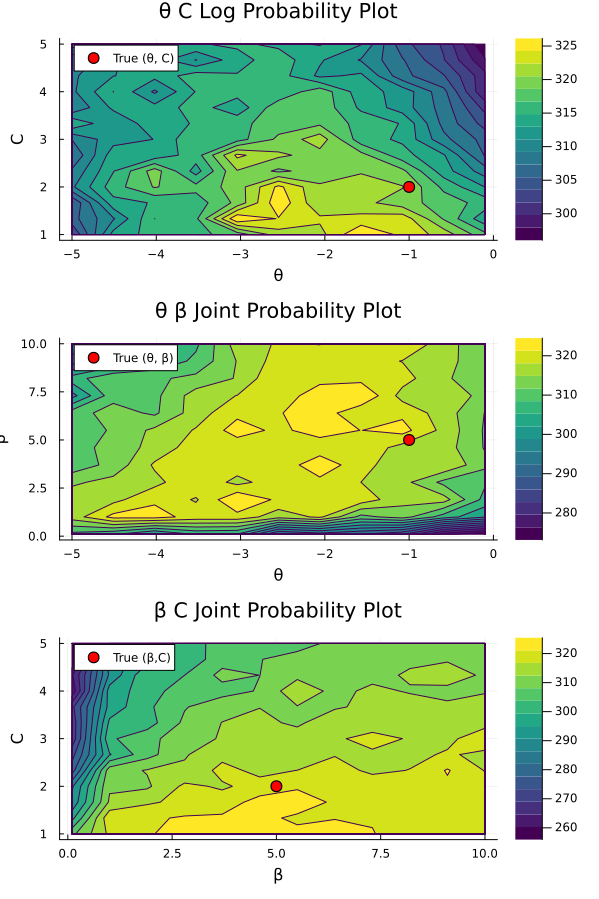

In [1]:

include("Julia_Implementation.jl")
using Random
using Distributions
using LinearAlgebra
using Statistics
using StatsFuns: logsumexp
using .Threads
using ProgressMeter
using SpecialFunctions
using Plots
using DataFrames
#Generating the noisy observations

num_particles = 1000

# 真实参数值
true_theta = -1.0
true_beta = 5.0
true_C = 2.0
#Searching range
theta_values = LinRange(-5.0, -0.1, 11)
beta_values = LinRange(0.1, 10.0, 12)
C_values = LinRange(1.0, 5.0, 13)

kw = 1.0
kv = 0.001
true_sigmaw2 = 0.2
true_sigmaw = sqrt(true_sigmaw2)
true_muw = 0.2
sigma_n = true_sigmaw * sqrt(kv)

# 模拟参数
T = 30.0
N = 5*round(Int,T) # resolution

# 定义Langevin动力学
A = zeros(2, 2)
A[1, 2] = 1.0
A[2, 2] = true_theta
h = [0.0 ; 1.0]
# 模拟
evaluation_points = range(0, T, length=N)
#print("Hi")

subordinator_jumps, jump_times = Julia_Implementation.vectorized_particle_Gamma_generator(true_beta, true_C, T, 1, 1, 10000)# subordinator jump sizes and times
SDE_samples = Julia_Implementation.generate_SDE_samples(subordinator_jumps[1,:],jump_times[1,:],true_muw,true_sigmaw,A,h,evaluation_points)
#print(size(samples))
Noisy_samples = SDE_samples[1, :] .+ randn(length(SDE_samples[1, :])) .* sigma_n




alphaw_prior = 2.1
betaw_prior = 1.0

# Pre-heating Run

warmup_log_probabilities = Julia_Implementation.Normal_Gamma_Langevin_Grid_Search(Noisy_samples,N,T,10,kw ,alphaw_prior,betaw_prior,kv, theta_values[1:3],beta_values[1:3], C_values[1:3])

fixed_beta_log_probabilities = Julia_Implementation.Normal_Gamma_Langevin_Grid_Search(Noisy_samples,N,T,num_particles,kw ,alphaw_prior,betaw_prior,kv, theta_values,[true_beta], C_values)
fixed_theta_log_probabilities = Julia_Implementation.Normal_Gamma_Langevin_Grid_Search(Noisy_samples,N,T,num_particles,kw ,alphaw_prior,betaw_prior,kv, [true_theta],beta_values, C_values)
fixed_C_log_probabilities = Julia_Implementation.Normal_Gamma_Langevin_Grid_Search(Noisy_samples,N,T,num_particles,kw ,alphaw_prior,betaw_prior,kv, theta_values,beta_values, [true_C])

fixed_beta_log_probabilities = fixed_beta_log_probabilities[:,1,:] #theta C
fixed_theta_log_probabilities = fixed_theta_log_probabilities[1,:,:] #beta C
fixed_C_log_probabilities = fixed_C_log_probabilities[:,:,1] #theta beta



# 绘制三个等高线图并将它们组合
p1 = contourf(theta_values, C_values, fixed_beta_log_probabilities',
              title="θ C Log Probability Plot",
              xlabel="θ", ylabel="C",
              color=:viridis)  # 使用viridis颜色图
scatter!(p1, [true_theta], [true_C], label="True (θ, C)", color=:red, markersize=6)  # 标记真实的θ和C值
p2 = contourf(theta_values, beta_values, fixed_C_log_probabilities',
              title="θ β Joint Probability Plot",
              xlabel="θ", ylabel="β",
              color=:viridis)  # 使用viridis颜色图
scatter!(p2, [true_theta], [true_beta], label="True (θ, β)", color=:red, markersize=6)  # 标记真实的θ和β值
p3 = contourf(beta_values, C_values, fixed_theta_log_probabilities',
              title="β C Joint Probability Plot",
              xlabel="β", ylabel="C",
              color=:viridis)  # 使用viridis颜色图
scatter!(p3, [true_beta], [true_C], label="True (β,C)", color=:red, markersize=6)  # 标记真实的C和β值
# 将三个图放在一个布局里面
plot(p1, p2, p3, layout=(3, 1), size=(600, 900))

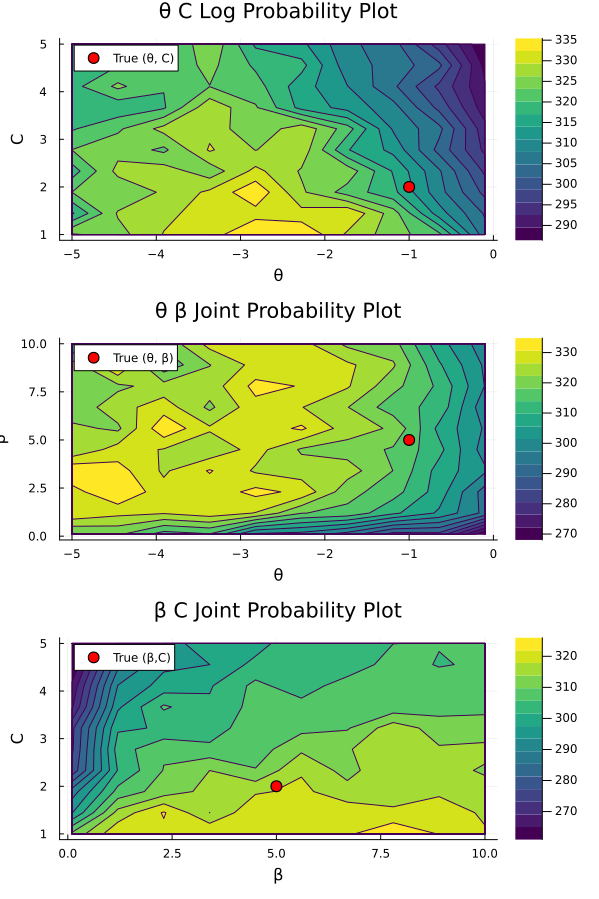

In [9]:
# 绘制三个等高线图并将它们组合
p1 = contourf(theta_values, C_values, fixed_beta_log_probabilities',
              title="θ C Log Probability Plot",
              xlabel="θ", ylabel="C",
              color=:viridis)  # 使用viridis颜色图
scatter!(p1, [true_theta], [true_C], label="True (θ, C)", color=:red, markersize=6)  # 标记真实的θ和C值
p2 = contourf(theta_values, beta_values, fixed_C_log_probabilities',
              title="θ β Joint Probability Plot",
              xlabel="θ", ylabel="β",
              color=:viridis)  # 使用viridis颜色图
scatter!(p2, [true_theta], [true_beta], label="True (θ, β)", color=:red, markersize=6)  # 标记真实的θ和β值
p3 = contourf(beta_values, C_values, fixed_theta_log_probabilities',
              title="β C Joint Probability Plot",
              xlabel="β", ylabel="C",
              color=:viridis)  # 使用viridis颜色图
scatter!(p3, [true_beta], [true_C], label="True (β,C)", color=:red, markersize=6)  # 标记真实的C和β值
# 将三个图放在一个布局里面
plot(p1, p2, p3, layout=(3, 1), size=(600, 900))